In [180]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
from matplotlib import cm
from matplotlib import colors as c
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters
import os

In [189]:
path = os.environ.get('GQPMC_DIR')
path+='/mini_mocha/ispeculator/james/'
print(path)

/Users/jameskwon/Documents/Research/Data/gqp_mc//mini_mocha/ispeculator/james/


In [201]:
specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample = 'mini_mocha') 

In [207]:
print(meta.keys())
input_mass = meta['logM_total'][:97]
input_sfr_100myr = meta['sfr_100myr'][:97]
input_sfr_1gyr = meta['sfr_1gyr'][:97]

dict_keys(['galid', 't_lookback', 'dt', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky', 'sfr_1gyr', 'sfr_100myr'])


In [191]:
sample_specphoto = h5py.File(path+'lgal.specphoto.noise_bgs0_legacy.emulator.0.mcmc.hdf5', 'r')
specphoto_param = np.array(sample_specphoto['theta_names'][...]).astype(str)
sample_photo = h5py.File(path+'lgal.photo.noise_legacy.emulator.0.mcmc.hdf5', 'r')
photo_param = np.array(sample_photo['theta_names'][...]).astype(str)

In [193]:
class plotter():
    def __init__(self,walkers,data_dir, igal):
        self.num_walkers = walkers
        self.igal = igal
        self.data_dir = data_dir
        self.f = h5py.File(self.data_dir,'r')
        self.mcmc_data = None
        specs,meta = Data.Spectra(sim='lgal',noise = 'none', lib = 'bc03', sample = 'mini_mocha')
        photo, _ = Data.Photometry(sim='lgal', noise= 'none', lib='bc03', sample = 'mini_mocha') 
        self.meta_data = meta
        self.prior = self.f['prior_range']
        
        
    def plot_raw(self,param_idx,all_data = False):
        keys = list(self.f.keys())
        # Get the number of mcmc_chain columns
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
        
        # If all_data == False, take the last mcmc_chain column
        if not all_data:
            self.mcmc_data = self.f[f'mcmc_chain{num}'][...][:,:,param_idx]

        # Otherwise, take all 
        else:
            self.mcmc_data = np.array([])
            for idx in range(num+1):
                self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        
        fig, ax = plt.subplots(1,1,figsize = (10,10))
        length = len(self.mcmc_data)//self.num_walkers
        for i in range(self.num_walkers):
            plt.plot(np.arange(length),self.mcmc_data[i::self.num_walkers], c = 'steelblue', lw = 0.5)
        plt.ylim(self.prior[param_idx])
        label = np.array(self.f['theta_names'][...]).astype(str)[param_idx]
        plt.ylabel(f'Prior Range\n{label})')
        plt.title(f'igal{self.igal} Walker Distribution {label}')
        plt.xlabel('Iteration')
        
    def plot_total_median(self,param_idx, inc = 1000, thin = 0):
        keys = list(self.f.keys())
        
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
                
        self.mcmc_data = np.array([])
        for idx in range(num+1):
            self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        
        walker_mcmc = []
        for i in range(self.num_walkers):
            walker_mcmc.append(self.mcmc_data[i::self.num_walkers])
            
        
        for i, walker in enumerate(walker_mcmc):
            running_median = []
            walker = walker[::thin]
            length = len(walker)
            for ii in range(length//inc):
                running_median.append(np.median(walker[:(ii+1)*inc:thin]))
            
            walker_mcmc[i] = running_median
        
        
        total_med = np.median(walker_mcmc,axis = 0)
        fig, ax = plt.subplots(1,1,figsize = (10,10))
        plt.plot(np.arange(len(total_med))*inc*self.num_walkers, total_med, c = 'steelblue', lw = 0.5)
        plt.ylim(self.prior[param_idx])
        label = np.array(self.f['theta_names'][...]).astype(str)[param_idx]
        plt.ylabel(f'Prior Range\n{label})')
        plt.title(f'igal{self.igal} Median {label}')
        plt.xlabel('Iteration')
        
    def plot_walker_median(self,param_idx,inc = 1000, thin = 0):
        keys = list(self.f.keys())
        
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
                
        self.mcmc_data = np.array([])
        for idx in range(num+1):
            self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        
        walker_mcmc = []
        for i in range(self.num_walkers):
            walker_mcmc.append(self.mcmc_data[i::self.num_walkers])
            
        
        for i, walker in enumerate(walker_mcmc):
            running_median = []
            walker = walker[::thin]
            length = len(walker)
            for ii in range(length//inc):
                running_median.append(np.median(walker[:(ii+1)*inc:thin]))
            
            walker_mcmc[i] = running_median
        
        
        fig, ax = plt.subplots(1,1,figsize = (10,10))
        for walker in walker_mcmc:
            ax.plot(np.arange(len(walker))*inc, walker, c = 'steelblue', lw = 0.5)
        plt.ylim(self.prior[param_idx])
        label = np.array(self.f['theta_names'][...]).astype(str)[param_idx]
        plt.ylabel(f'Prior Range\n{label})')
        plt.title(f'igal{self.igal} Walker Median {label}')
        plt.xlabel('Iteration')
            
    def report_median(self,param_idx,all_data = False):
        keys = list(self.f.keys())
        print(self.f['theta_names'][...])
        
        num = -1
        for k in keys:
            if 'mcmc_chain' in k:
                num += 1
        if not all_data:
            self.mcmc_data = self.f[f'mcmc_chain{num}'][...][:,:,param_idx]
        else:
            self.mcmc_data = np.array([])
            for idx in range(num+1):
                self.mcmc_data = np.append(self.mcmc_data,self.f[f'mcmc_chain{idx}'][...][:,:,param_idx])
        med = np.median(self.mcmc_data)
        
        print(med)
        return med

In [194]:
specphoto_param_medians = {}
for n, param in enumerate(specphoto_param):
    param_med = []
    for i in range(97):
        try: 
            obj = plotter(40,f'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/james/lgal.specphoto.noise_bgs0_legacy.emulator.{i}.mcmc.hdf5',i)
    #         obj.plot_total_median(param_idx, True,10)
    #         obj.plot_walker_median(param_idx,thin = 1)
    #         obj.plot_raw(param_idx)
            med = obj.report_median(n,True)
            param_med.append(med)
        except:
            print('file not found')
            param_med.append('N/A')
    specphoto_param_medians[param] = param_med

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
9.86246709128083
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.782803519817467
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.921900644199695
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.096586284059946
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.221394216101134
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.527312575887622
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.4716692213598
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.189425434868603
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
9.933139763615763
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.430801515426069
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.955161432987683
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
10.420294425352695
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
9.898734791840933
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
11.161031923286835
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' 

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.013396152878953016
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
7.303904476452239e-06
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0010168426045226164
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.1561648054498811
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
8.361748508378675e-06
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.2278722448084205
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.01038722976166817
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh'

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.5621833533090101
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.9987765922142862
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.9538373893859219
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.61875306085103
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.7186332621534615
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.09386179409467077
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.7251008289542699
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh'

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.07024056854262814
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.800649736128455
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.9996093123250543
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.452875940777549
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.03269990587653705
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.9917697265614115
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.7882388680453202
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh

2.680752807645049e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
1.0006248582445498e-06
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
2.7258978722362265e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.006854674166549845
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
1.3614797642690694e-06
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0012382798173763184
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00077423772252092
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.09642920345997849
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sf

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.08668014201941673
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0009025109955122147
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.004319570057145726
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.046236976533754755
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.12872146532968481
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.005556971156432184
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.032907132910918103
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.08229324700564233
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.03735133117582176
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.058498237670215066
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00029194860224730703
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.15852791643761052
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.03191077160935516
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00782340165556769
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' 

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0003077299072251815
file not found
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0002659555371231135
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
7.960802139179144e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0007965678435125956
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00021999216686013255
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.007256589301882691
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00021250599363576518
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00022299916349195555
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0001844060286508791
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0007359854925753805
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0001470571842123141
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0005853725909650514
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00023342443955391796
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0001232141901992243
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00011001388783733222
file not found
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0003602266805568699
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0001374229549214616
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
8.327368828479033e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.0002766712090732136
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.000328562555085672
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.00018538084118453331
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
1.0556465465585398
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
1.2295165272868043
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.9826050603531593
file not found
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.6963994006566647
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
1.4650886699576167
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.49932764139333047
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.1389438935482117
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
1.4132240737081294
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.21745887523124055
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.18602131774517242
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.008399714432752404
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.4055539882199904
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.2598354444221946
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.3680069626369573
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.3164936791588118
file not found
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.11155503959553352
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.14451413166423782
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.2699730014098696
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.21215087456944773
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.5225789472828275
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau' b'f_fiber']
0.3773016919143154
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamm

In [197]:
f_exist = os.path.isfile('specphoto_param_medians.npy')
np.save('specphoto_param.medians.npy', np.array(specphoto_param_medians))

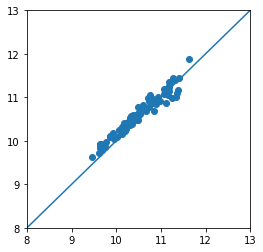

In [230]:
for item in list(specphoto_param_medians.items()):
    plt.figure(figsize = (4,4))
    key, val = item
    val = np.array(val)
    input_mass = np.array(input_mass)
    mask = (val != 'N/A')
    ar1 = input_mass[mask]
    plt.scatter(input_mass[mask],val[mask].astype(float))
    plt.plot([8,13],[8,13])
    plt.xlim(8,13)
    plt.ylim(8,13)
    break
    

In [231]:
photo_param_mediaans = {}
for n, param in enumerate(photo_param):
    param_med = []
    for i in range(97):
        try: 
            obj = plotter(40,f'/Users/jameskwon/Documents/Research/Data/gqp_mc/mini_mocha/ispeculator/james/lgal.photo.noise_legacy.emulator.{i}.mcmc.hdf5',i)
    #         obj.plot_total_median(param_idx, True,10)
    #         obj.plot_walker_median(param_idx,thin = 1)
    #         obj.plot_raw(param_idx)
            med = obj.report_median(n,True)
            param_med.append(med)
        except:
            print('file not found')
            param_med.append('N/A')
    photo_param_medians[param] = param_med

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
9.874858404697608
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.791574028677493
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.930754759917496
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.108259333607755
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.214381770999116
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.513329823109686
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.479999823230488
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.58897760236231
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
11.238011232035065
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.714411225033263
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
11.30628520981489
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.893487290720872
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
11.294984461172024
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.390618144479758
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.518708258822894
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
10.821780144088217
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sf

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.005986866683625247
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.008467727804774672
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.13653956350960927
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0008092768936799333
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.08241043897420475
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
3.5044543211348866e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.003609472614343745
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.004383115111643243
[b'logmstar' b'beta1_sfh' b'bet

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.2539598087498691
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.9879113072397274
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.2059514537456633
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.7297594189615353
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.3161581314187896
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.8881886773335372
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.7860618625840973
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.5749088403486379
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_s

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.944656813917559
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.7395880700358313
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.17670146990142468
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.9836438659536099
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.9980496977690372
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.13550073071708665
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.04561649976730638
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.010617562737224867
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'bet

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.011211318429564347
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.01184960900068939
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.12267192840716981
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.002831603106368341
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.00010137496452269867
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.004000301815635458
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.13051493710613846
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.00017804335641640606
[b'logmstar' b'beta1_sfh' b'bet

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0056155211385783416
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.02552698597824791
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.02188315760215406
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.09008240515310281
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.003975070164102518
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.013374046098168394
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.12677795512818918
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.07260087460324494
[b'logmstar' b'beta1_sfh' b'beta2_sf

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0015112901694219359
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0016276206156587126
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0001396363775917961
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.000946823830928399
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0021020383585549137
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
9.302430692215807e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0010511958140666166
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.001398367751465609
[b'logmstar' b'beta1_sfh' 

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.00012439694179819567
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0011370897921486782
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0012284553743045139
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.00019254680483932912
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0005354627987699488
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.00015845589535396466
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.001440130707041747
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.001121520808924646
[b'logmstar' b'beta1_sf

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0006023609369839498
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.00010269318864844517
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.000765840126100632
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
7.821579040796038e-05
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0006068562509873981
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.001110457568745627
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0010942805252344009
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.0009855404758304545
[b'logmstar' b'beta1_sfh'

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.268977386710725
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.04105528848941468
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.5588326933037779
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.91083321674689
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.041488775684654436
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
1.2469872858442557
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
1.3880864654829748
[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
1.137110476042455
file not found
[b'logmstar' b'beta1_sfh' b'beta2_

[b'logmstar' b'beta1_sfh' b'beta2_sfh' b'beta3_sfh' b'beta4_sfh'
 b'gamma1_zh' b'gamma2_zh' b'tau']
0.1046773634473719


In [232]:
f_exist = os.path.isfile('photo_param_medians.npy')
np.save('photo_param.medians.npy', np.array(photo_param_medians))

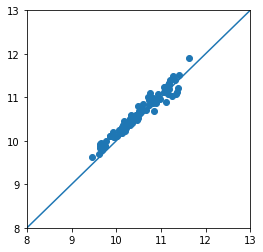

In [233]:
for item in list(photo_param_medians.items()):
    plt.figure(figsize = (4,4))
    key, val = item
    val = np.array(val)
    input_mass = np.array(input_mass)
    mask = (val != 'N/A')
    ar1 = input_mass[mask]
    plt.scatter(input_mass[mask],val[mask].astype(float))
    plt.plot([8,13],[8,13])
    plt.xlim(8,13)
    plt.ylim(8,13)
    break
    